# Using machine learning to understand the treatment effect of Ozempic
## By Mrimon (Nemo) Guha

In [89]:
#Importing libraries for different packages and functions
import pandas as pd
import py7zr
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, mean_squared_error, r2_score

import statsmodels.api as sm
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso, LogisticRegression, LogisticRegressionCV, LassoCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer


In [90]:
# Path to your .7z file
file_path = 'longyear-obese-hypertensive-40-57-medical-SMALL-sample.7z'

# Open the .7z file
with py7zr.SevenZipFile(file_path, mode='r') as z:
    all_files = z.getnames()
    # Assuming there's only one CSV file in the .7z archive
    csv_file_name = all_files[0]
    # Extract the CSV file to memory
    csv_file_dict = z.read([csv_file_name])
    csv_file = csv_file_dict[csv_file_name]

# Load the CSV data into a pandas DataFrame
df_main = pd.read_csv(csv_file)

# Now you can work with the DataFrame `df` as usual
file_path = 'longyear-obese-hypertensive-40-75-scripts-SMALL-sample.7z'

# Open the .7z file
with py7zr.SevenZipFile(file_path, mode='r') as z:
    all_files = z.getnames()
    # Assuming there's only one CSV file in the .7z archive
    csv_file_name = all_files[0]
    # Extract the CSV file to memory
    csv_file_dict = z.read([csv_file_name])
    csv_file = csv_file_dict[csv_file_name]

# Load the CSV data into a pandas DataFrame
df2_main = pd.read_csv(csv_file)

/var/folders/bs/gxskxrlj2n71b4v0t6wzkylc0000gn/T/ipykernel_4848/148572576.py:29: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df2_main = pd.read_csv(csv_file)


In [91]:
#I have created multiple copies of the dataframes for easier and simpler use and analysis
df= df_main
df_1=df_main

df2=df2_main
df_2=df2_main

## Part 1
### Exploratory Data Analysis (EDA): 
* Conducting a thorough exploration of the provided datasets. This includes understanding the structure, identifying missing values, and summarizing key statistics. 
* Generating visualizations to understand the distribution of important variables, relationships between different variables, and any other patterns or anomalies in the data such as peculiar patterns or outliers.

In [92]:
#To find the percentage of nulls in dataframe
df.isnull().mean()*100

journey_id            0.000000
episode_id            0.000000
visit_id              0.300710
encounter_id          0.000000
claim_date            0.000000
patient_state         0.000000
patient_short_zip     0.002085
patient_age           1.049677
patient_gender        0.000000
place_of_service     22.287799
visit_type            3.700092
payor                 2.339762
payor_channel         6.004410
ref_npi              52.287238
hcp_npi              30.291007
hcp_taxonomy         31.324486
hcp_specialty        31.321278
hco_npi               0.919931
hcp_npi_list         30.291007
hco_npi_list          0.919931
diag_list             0.139529
diag_1                0.139529
diag_2               26.130468
diag_3               41.416302
diag_4               52.169841
diag_5               67.119843
rev_center_code      81.728720
rev_center_units      0.315464
proc_code             3.835131
proc_modifier        73.385510
proc_units            0.351870
line_charge           0.000000
claim_ch

In [93]:
df2.isnull().mean()*100

journey_id                        0.000000
cohort_id                         0.000000
claim_id                          0.000000
patient_gender                    0.000000
patient_state                     0.000000
patient_zip                       0.000000
patient_dob                       0.000000
pharmacy_npi                      0.000000
pharmacist_npi                    0.000000
prescriber_npi                    0.000000
primary_care_npi                  0.000000
group_id                          0.000000
date_of_service                   0.000000
date_authorized                   0.000000
transaction_type                  0.000000
date_prescription_written         0.000000
ndc11                             0.000000
ndc11_original                    0.000000
number_of_refills_authorized      5.041677
diagnosis_code                    9.003569
diagnosis_code_type               0.000000
quantity_prescribed_original     63.968286
quantity_dispensed                0.000782
place_of_se

In [94]:
#I see that rev center code, proc modifier, coupon value amount, daw code columns have >60% nulls 
#so dropping them for analysis
df = df.drop(["rev_center_code","proc_modifier"], axis=1)
df2=df2.drop(["coupon_value_amount","daw_code"],axis=1)

## PART 2
### Data Preprocessing and Merging
* Preparing the datasets for analysis by handling missing data, encoding categorical variables, and any other necessary preprocessing steps

In [95]:
#For other columns, I am imputing the null values with mean and mode values
#DF1
df['patient_age'].fillna(df['patient_age'].mean(), inplace=True)
df['ref_npi'].fillna(df['ref_npi'].mean(),inplace=True)
df['hcp_npi'].fillna(df['hcp_npi'].mean(),inplace=True)
df['hcp_taxonomy'].fillna(df['hcp_taxonomy'].mode()[0],inplace=True)
df['hcp_specialty'].fillna(df['hcp_specialty'].mode()[0],inplace=True)
df['hcp_npi_list'].fillna(df['hcp_npi_list'].mode()[0],inplace=True)
df['diag_2'].fillna(df['diag_2'].mode()[0],inplace=True)
df['diag_4'].fillna(df['diag_4'].mode()[0],inplace=True)
df['diag_5'].fillna(df['diag_5'].mode()[0],inplace=True)
df['place_of_service'].fillna(df['place_of_service'].mode()[0],inplace=True)

#DF2
df2['pharmacy_submitted_cost'].fillna(df2['pharmacy_submitted_cost'].mean(), inplace=True)
df2['plan_pay'].fillna(df2['plan_pay'].mean(),inplace=True)
df2['prior_authorization_type_code'].fillna(df2['prior_authorization_type_code'].mode()[0],inplace=True)
df2['patient_pay'].fillna(df2['patient_pay'].mean(),inplace=True)
df2['copay_coinsurance'].fillna(df2['copay_coinsurance'].mean(),inplace=True)

#I have also removed any duplicates that would be in the datasets
df=df.drop_duplicates()
df2=df2.drop_duplicates()

##  GRAPHS:

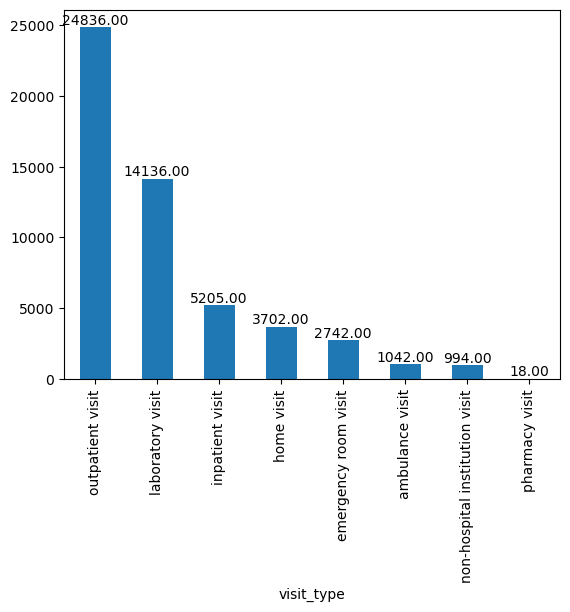

In [96]:
#Patients visit vs visit type 
patient_state_cnt = df.groupby('visit_type')['journey_id'].nunique().sort_values(ascending=False)

patient_state_cnt .plot.bar()
for i, v in enumerate(patient_state_cnt):
    plt.text(i, v, f'{v:.2f}', ha='center', va='bottom')

plt.show()

###  Intrepretation: Based on the graph, we can see that most of the visits made are for outpatient visitations followed by labrotaory visits which are for blood tests etc. Very few details are present for pharmacy or non-hospital instution visitations.

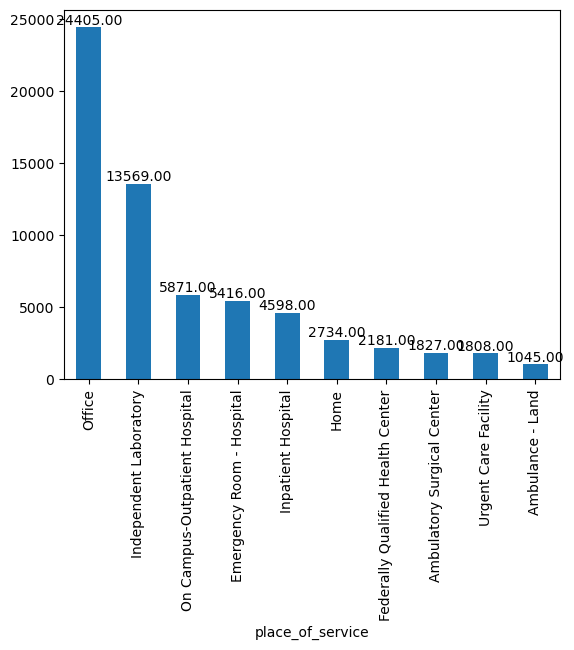

In [97]:
#Visits based on places of service
patient_state_cnt = df.groupby('place_of_service')['journey_id'].nunique().sort_values(ascending=False).head(10)

patient_state_cnt .plot.bar()
for i, v in enumerate(patient_state_cnt):
    plt.text(i, v, f'{v:.2f}', ha='center', va='bottom')

plt.show()

###  Intrepretation: Offices, independent laboratory, on campus hospitals are the most common places of service for the patients. Urgent care facilities, surgical centers have relatively lower number of patients visiting them

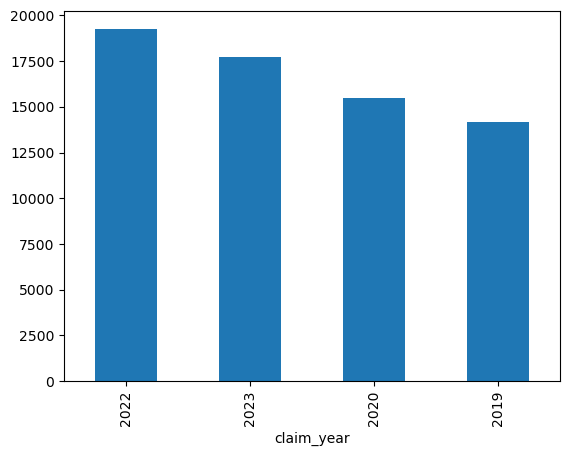

In [98]:
# Year wise patient distribution
df['claim_date'] = pd.to_datetime(df['claim_date'])
df['claim_year'] = df['claim_date'].dt.year
patient_state_cnt = df.groupby('claim_year')['journey_id'].nunique().sort_values(ascending=False).head(10)


patient_state_cnt .plot.bar()
plt.show()

### Intrepretation: Over the course of years, 2022 had the most number of patients. 2023 had the second most, this also could be an indicator that the dataset is not complete and will potentially change once 2023 data is added. There has also been an interesting increase post covid and more patients in general over the years.

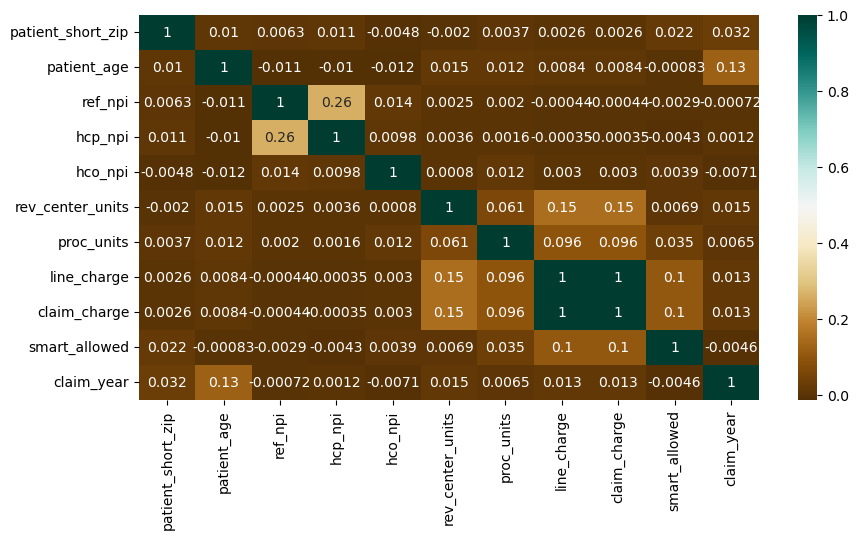

In [99]:
#Heatmap for the numerical columns of the dataframe
plt.figure(figsize=(10, 5))
colum  = [
    'patient_short_zip',
    'patient_age',
    'ref_npi',
    'hcp_npi',
    'hco_npi',
    'rev_center_units',
    'proc_units',
    'line_charge',
    'claim_charge',
    'smart_allowed',
    'claim_year'
]

corrl = df[colum].corr()
sns.heatmap(corrl, cmap="BrBG", annot=True)
plt.show()

### Intrepretation: From the heatmap, we can see that most of the variables have no correlation with each other especially since most of the values are way less than 0.

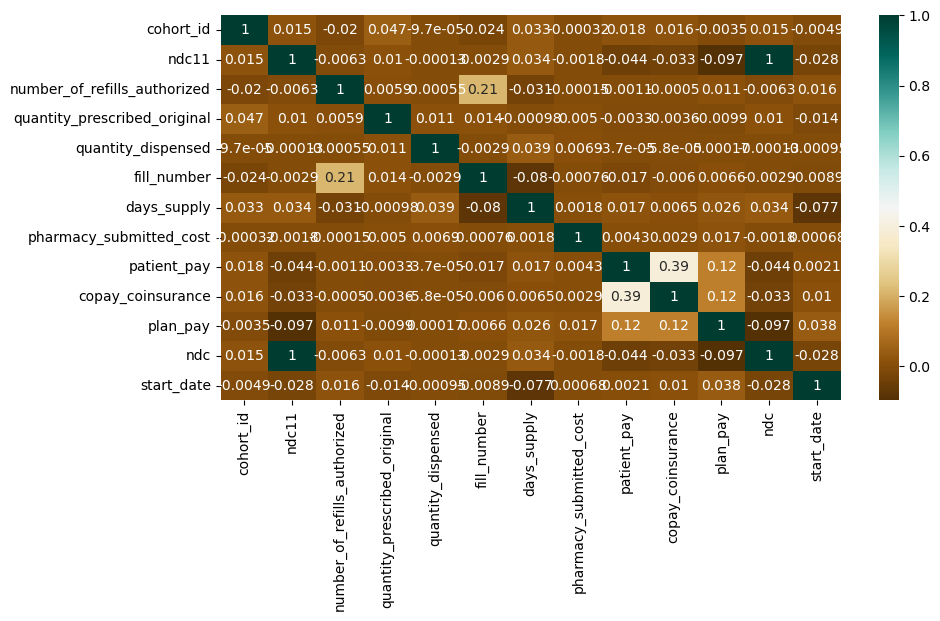

In [100]:
#Heatmap for scripts data
plt.figure(figsize=(10, 5))
columns = [
    'cohort_id',
    'ndc11',
    'number_of_refills_authorized',
    'quantity_prescribed_original',
    'quantity_dispensed',
    'fill_number',
    'days_supply',
    'pharmacy_submitted_cost',
    'patient_pay',
    'copay_coinsurance',
    'plan_pay',
    'ndc',
    'start_date'
]

corrl = df2[columns].corr()
sns.heatmap(corrl, cmap="BrBG", annot=True)
plt.show()

### Intrepretation: From the heatmap, we can see that variables- ndc and ndc11 are correlated as they are the same drug codes represented in different formats. There is a slight correlation between patient pay and co pay co insurance values.

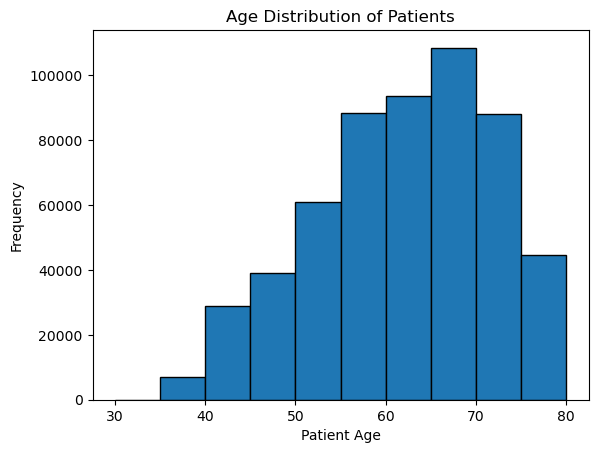

In [101]:
# Age distribution of patients 
plt.hist(df['patient_age'], edgecolor='black')

plt.xlabel('Patient Age')
plt.ylabel('Frequency')
plt.title('Age Distribution of Patients')

# Show the histogram
plt.show()

### intrepretation: Patinets from the age group 65 to 70 are most frequently present in the dataset. Youngeer people do not have a lot of records signifying better health.

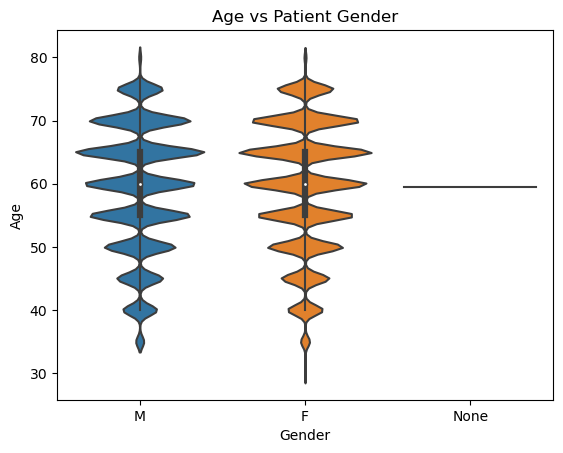

In [102]:
sns.violinplot(x='patient_gender', y='patient_age', data=df)
plt.xlabel('Gender')
plt.ylabel('Age')
plt.title('Age vs Patient Gender')
plt.show()

### Intrepretation: Females are more spread apart and more widely present in the data. Females also belong to age group 30-80, males data start from 35-80.

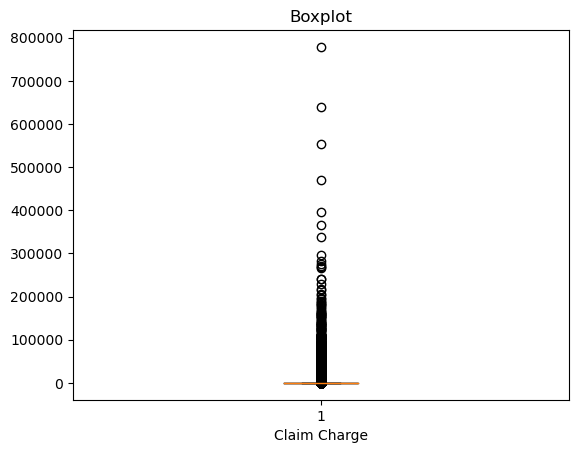

In [103]:
plt.boxplot(df['claim_charge'], vert=True)
plt.xlabel('Claim Charge')
plt.title('Boxplot')

# Show the plot
plt.show()

This graph is not very clear and we need to transform the variables

/Users/mrimonguha/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


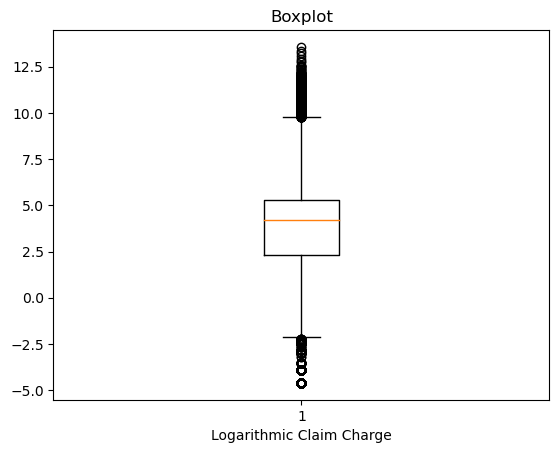

In [104]:
#We have rescaled and transformed the claim charge value for better representation
plt.boxplot(np.log(df['claim_charge']))
plt.xlabel('Logarithmic Claim Charge')
plt.title('Boxplot')
plt.show()

### Intrepretation: We can spot many outliers for claim charge, log(claim charge) has an interquartile range of 2.5

###### OZEMPIC PROC CODES
Based on my research, Ozempic uses these proc codes:
J3490, C9399
Refer to :
    * https://www.uhcprovider.com/content/dam/provider/docs/public/policies/attachments/self-administered-medications-list.pdf

In [105]:
#Filtering for ozempic patients
filtered_df = df[df['proc_code'].isin(["C9399", "J3490"])]
oz_df= df2.loc[df2['journey_id'].isin(filtered_df['journey_id'])]

In [106]:
oz_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20421 entries, 4788 to 894114
Data columns (total 46 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   journey_id                     20421 non-null  object 
 1   cohort_id                      20421 non-null  int64  
 2   claim_id                       20421 non-null  object 
 3   patient_gender                 20421 non-null  object 
 4   patient_state                  20421 non-null  object 
 5   patient_zip                    20421 non-null  object 
 6   patient_dob                    20421 non-null  object 
 7   pharmacy_npi                   20421 non-null  object 
 8   pharmacist_npi                 20421 non-null  object 
 9   prescriber_npi                 20421 non-null  object 
 10  primary_care_npi               20421 non-null  object 
 11  group_id                       20421 non-null  object 
 12  date_of_service                20421 non-n

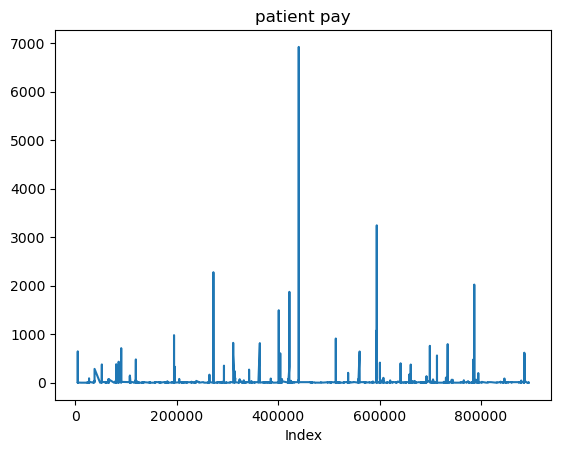

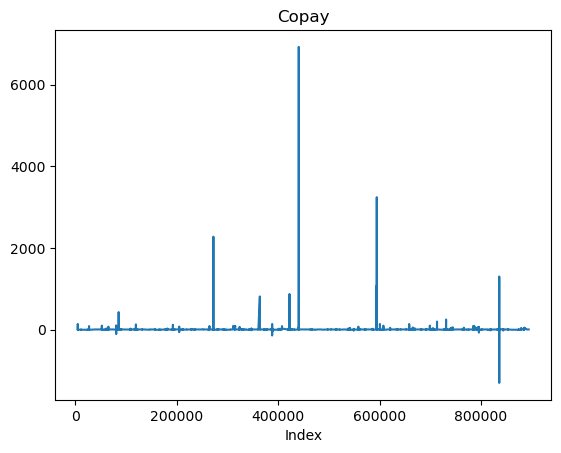

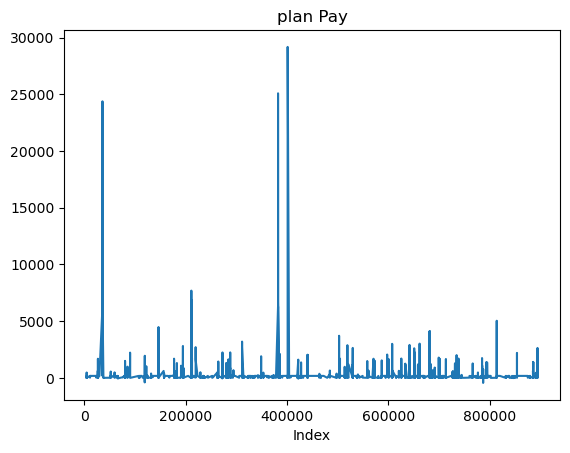

In [107]:
#Ozempic patients
oz_df['patient_pay'].plot(kind='line')
plt.title('patient pay')
plt.xlabel('Index')
plt.show()

oz_df['copay_coinsurance'].plot(kind='line')
plt.title('Copay')
plt.xlabel('Index')
plt.show()


oz_df['plan_pay'].plot(kind='line')
plt.title('plan Pay')
plt.xlabel('Index')
plt.show()

### Intrepretation: 
I have done analysis of different pay amount values, maximum values are as:
* Plan- $$30,000
* Patient- $7,000
* Copay- $6,500


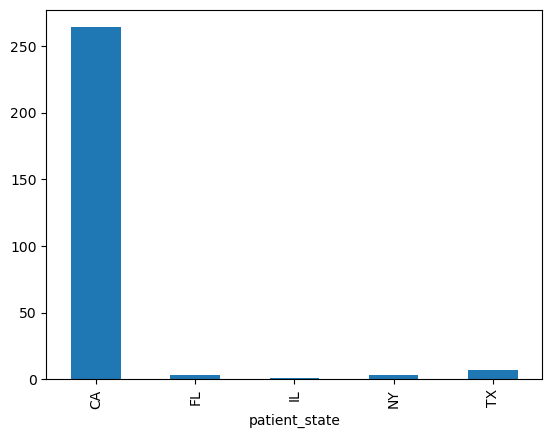

In [108]:
#state wise distribution
oz_df.groupby('patient_state')['journey_id'].nunique().plot.bar()
plt.show()

### Intrepretation: California has the most ozempic users ( this could be due to the population and Hollywood's abuse of Ozempic for weight loss) in the top 5 followed by Texas.

In [109]:
# Listing the different data types of the dataframe
df.dtypes

journey_id                   object
episode_id                   object
visit_id                     object
encounter_id                 object
claim_date           datetime64[ns]
patient_state                object
patient_short_zip           float64
patient_age                 float64
patient_gender               object
place_of_service             object
visit_type                   object
payor                        object
payor_channel                object
ref_npi                     float64
hcp_npi                     float64
hcp_taxonomy                 object
hcp_specialty                object
hco_npi                     float64
hcp_npi_list                 object
hco_npi_list                 object
diag_list                    object
diag_1                       object
diag_2                       object
diag_3                       object
diag_4                       object
diag_5                       object
rev_center_units            float64
proc_code                   

In [110]:
#Here, I am encoding the variables using labelencoder()
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

df['journey_id'] = label_encoder.fit_transform(df['journey_id'])
df['episode_id'] = label_encoder.fit_transform(df['episode_id'])
df['visit_id'] = label_encoder.fit_transform(df['visit_id'])
df['encounter_id'] = label_encoder.fit_transform(df['encounter_id'])
df['patient_state'] = label_encoder.fit_transform(df['patient_state'])
df['patient_gender'] = label_encoder.fit_transform(df['patient_gender'])
df['place_of_service'] = label_encoder.fit_transform(df['place_of_service'])
df['visit_type'] = label_encoder.fit_transform(df['visit_type'])
df['payor'] = label_encoder.fit_transform(df['payor'])
df['payor_channel'] = label_encoder.fit_transform(df['payor_channel'])
df['hcp_taxonomy'] = label_encoder.fit_transform(df['hcp_taxonomy'])
df['hcp_specialty'] = label_encoder.fit_transform(df['hcp_specialty'])
df['hcp_npi_list'] = label_encoder.fit_transform(df['hcp_npi_list'])
df['hco_npi_list'] = label_encoder.fit_transform(df['hco_npi_list'])
df['diag_list'] = label_encoder.fit_transform(df['diag_list'])
df['diag_1'] = label_encoder.fit_transform(df['diag_1'])
df['diag_2'] = label_encoder.fit_transform(df['diag_2'])
df['diag_3'] = label_encoder.fit_transform(df['diag_3'])
df['diag_4'] = label_encoder.fit_transform(df['diag_4'])
df['diag_5'] = label_encoder.fit_transform(df['diag_5'])
df['proc_code'] = label_encoder.fit_transform(df['proc_code'])


In [111]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 893390 entries, 0 to 894622
Data columns (total 46 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   journey_id                     893390 non-null  object 
 1   cohort_id                      893390 non-null  int64  
 2   claim_id                       893390 non-null  object 
 3   patient_gender                 893390 non-null  object 
 4   patient_state                  893390 non-null  object 
 5   patient_zip                    893390 non-null  object 
 6   patient_dob                    893390 non-null  object 
 7   pharmacy_npi                   893390 non-null  object 
 8   pharmacist_npi                 893390 non-null  object 
 9   prescriber_npi                 893390 non-null  object 
 10  primary_care_npi               893390 non-null  object 
 11  group_id                       893390 non-null  object 
 12  date_of_service               

In [112]:
#Now, I am encoding the Prescriptions data
df2['journey_id'] = label_encoder.fit_transform(df2['journey_id'])
df2['claim_id'] = label_encoder.fit_transform(df2['claim_id'])
df2['patient_gender'] = label_encoder.fit_transform(df2['patient_gender'])
df2['pharmacy_npi'] = label_encoder.fit_transform(df2['pharmacy_npi'])
df2['pharmacist_npi'] = label_encoder.fit_transform(df2['pharmacist_npi'])
df2['prescriber_npi'] = label_encoder.fit_transform(df2['prescriber_npi'])
df2['primary_care_npi'] = label_encoder.fit_transform(df2['primary_care_npi'])
df2['group_id'] = label_encoder.fit_transform(df2['group_id'])
df2['date_of_service'] = label_encoder.fit_transform(df2['date_of_service'])
df2['date_authorized'] = label_encoder.fit_transform(df2['date_authorized'])
df2['transaction_type'] = label_encoder.fit_transform(df2['transaction_type'])
df2['date_prescription_written'] = label_encoder.fit_transform(df2['date_prescription_written'])
df2['ndc11_original'] = label_encoder.fit_transform(df2['ndc11_original'])
df2['diagnosis_code'] = label_encoder.fit_transform(df2['diagnosis_code'])
df2['diagnosis_code_type'] = label_encoder.fit_transform(df2['diagnosis_code_type'])
df2['unit_of_measure'] = label_encoder.fit_transform(df2['unit_of_measure'])
df2['pcn'] = label_encoder.fit_transform(df2['pcn'])
df2['bin'] = label_encoder.fit_transform(df2['bin'])
df2['reject_code_1'] = label_encoder.fit_transform(df2['reject_code_1'])
df2['reject_code_3'] = label_encoder.fit_transform(df2['reject_code_3'])
df2['reject_code_4'] = label_encoder.fit_transform(df2['reject_code_4'])
df2['reject_code_5'] = label_encoder.fit_transform(df2['reject_code_5'])
df2['end_date'] = label_encoder.fit_transform(df2['end_date'])


## PART 3
### Causal Analysis Setup: 


These are the potential endogeneity issues that could take place when we are estimating the treatment effect of Ozempic of the target population:
* Influence of other drugs, other medications could also impact the measurement of the influence of Ozempic on patient's health 
* Several other factors could also influence our treatment effect such as age, gender, sex
* Fitness levels, genetic conditions also play an important role in overall blood sugar levels, treatmeent effects could be varying based on these. An individual who is physically active and has a history of exercise regularly is more likely to react differently to Ozempic compared to someone who does not
* It is also possible to have biases in the data as some users might not be explicitly revealing perrsonal information
* During the process of procuring data, there could be several errors and we could have incorrect values leading to poor treatmeent effects

Our strategy to address endogeneity is that we have considered the variable "smart_allowed". This variable consists of the amount of the amounts being spent on the patients treatements. 
* I believe that with this variable, I would be able to track if there is any effect on the amount being spent for Ozempic patients. I want to see if people using Ozempic are spending more or less compared to other patients in the longer run.
* I feel this would help me also to tackle some of the other variables that are not considered such as genetics, geography. The conditions such as genetics would be similar when considering payment for the first visit as well as for the payment for last visit.

When we are referring to establish cause and effect in a study or observation, our goal is to mainly measure how one variable may be influencing other variable. It can be difficult to completely understand the treatment effects as there are many variables and confounding variables that could be impacting the treatment (Ozempic administration in our case)



In [113]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 893390 entries, 0 to 894622
Data columns (total 46 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   journey_id                     893390 non-null  int64  
 1   cohort_id                      893390 non-null  int64  
 2   claim_id                       893390 non-null  int64  
 3   patient_gender                 893390 non-null  int64  
 4   patient_state                  893390 non-null  object 
 5   patient_zip                    893390 non-null  object 
 6   patient_dob                    893390 non-null  object 
 7   pharmacy_npi                   893390 non-null  int64  
 8   pharmacist_npi                 893390 non-null  int64  
 9   prescriber_npi                 893390 non-null  int64  
 10  primary_care_npi               893390 non-null  int64  
 11  group_id                       893390 non-null  int64  
 12  date_of_service               

## PART 4. Model Development: Double-Lasso / Treatment Effect Lasso 
* Implementing the double-lasso technique to estimate the treatment effect of Ozempic, considering the endogeneity of treatment assignmen

###### Ozempic codes for ndc column:
REFER to https://dailymed.nlm.nih.gov/dailymed/drugInfo.cfm?setid=adec4fd2-6858-4c99-91d4-531f5f2a2d796

In [114]:
#Considering only ozempic codes 
ozem2=df2_main[df2_main['ndc11'].isin([169413001, 169413013, 169413211, 169413212,
169413290, 169413297, 169413602, 169413611, 169418103, 169418113, 169418190, 169418197, 169477211, 169477212
, 169477290, 169477297])]

In [115]:
#To define bins for conversion of continuous to discrete for y-variable

min_value = df_main['smart_allowed'].min()
max_value = df_main['smart_allowed'].max()

ranges = max_value - min_value
print(ranges)

45035.96


##### Referred to: https://www.blog.trainindata.com/lasso-feature-selection-with-python/ for feature selection using Lasso

In [116]:
#I am trying to find out different features we can select for the model. Feature selection using Lasso is done
#Dropping y-variable which is smart allowed in our case
df_x = df_main.drop(columns=['smart_allowed'])

#I am choosing only numerical variables 
df_x = df_x.select_dtypes(include=['number'])
X = pd.DataFrame(df_x)

#Converting continous to discrete variables using 10 bins
y = pd.cut(df_main['smart_allowed'], bins=10)

#I am replacing the nulls with "mean"
#https://www.analyticsvidhya.com/blog/2022/10/handling-missing-data-with-simpleimputer/
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)

#Training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

#Encoding the categorical variables
y_train2 = label_encoder.fit_transform(y_train)
y_test2 = label_encoder.transform(y_test)

scaler = StandardScaler()
scaler.fit(X_train)

#l1 is Lasso, running a Lasso regularisation model
select = SelectFromModel(
    LogisticRegression(C=0.2, penalty='l1', solver='liblinear', random_state=10))


select.fit(scaler.transform(X_train), y_train2)


#Selecting the features from the model 
selected_features = X_train[:, select.get_support()]
X_train_selected = select.transform(scaler.transform(X_train))
X_test_selected = select.transform(scaler.transform(X_test))

In [117]:
#Displaying Selected Features
selected_feature_indices = select.get_support()
selected_column_names = df_x.columns[selected_feature_indices]
print("Selected columns are as follows-")
print(selected_column_names)

Selected columns are as follows-
Index(['patient_short_zip', 'patient_age', 'ref_npi', 'hcp_npi', 'hco_npi',
       'rev_center_code', 'rev_center_units', 'proc_units', 'line_charge',
       'claim_charge'],
      dtype='object')


In [118]:
import numpy as np
from scipy.optimize import minimize
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import log_loss

class SelectiveRegularizationLogisticRegression(BaseEstimator, ClassifierMixin):
    def __init__(self, penalty_indices, penalty_weights, tol=1e-4, max_iter=100):
        self.penalty_indices = penalty_indices
        self.penalty_weights = penalty_weights
        self.tol = tol
        self.max_iter = max_iter
    
    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def _loss(self, coef, X, y):
        predictions = self._sigmoid(X @ coef)
        # Basic log loss
        basic_loss = log_loss(y, predictions)
        
        # Regularization term, selectively applied with L1 penalty
        reg_term = sum(self.penalty_weights[i] * abs(coef[self.penalty_indices[i]]) for i in range(len(self.penalty_indices)))
        
        return basic_loss + reg_term
    
    def fit(self, X, y):
        # Add intercept term
        X = np.hstack([np.ones((X.shape[0], 1)), X])
        
        initial_coef = np.zeros(X.shape[1])
        result = minimize(self._loss, initial_coef, args=(X, y), method='SLSQP', tol=self.tol, options={'maxiter': self.max_iter})
        
        self.coef_ = result.x
        return self
    
    def predict_proba(self, X):
        X = np.hstack([np.ones((X.shape[0], 1)), X])
        proba = self._sigmoid(X @ self.coef_)
        return np.vstack([1-proba, proba]).T
    
    def predict(self, X):
        return (self.predict_proba(X)[:, 1] > 0.5).astype(int)

In [119]:
df_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 623525 entries, 0 to 623524
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   patient_short_zip  623512 non-null  float64
 1   patient_age        616980 non-null  float64
 2   ref_npi            297501 non-null  float64
 3   hcp_npi            434653 non-null  float64
 4   hco_npi            617789 non-null  float64
 5   rev_center_code    113926 non-null  float64
 6   rev_center_units   621558 non-null  float64
 7   proc_units         621331 non-null  float64
 8   line_charge        623525 non-null  float64
 9   claim_charge       623525 non-null  float64
dtypes: float64(10)
memory usage: 47.6 MB


In [120]:
df_x = df_main
#Creating a new column 'ozempic' which I set to 1 for all users using Ozempic.I have found proc codes for Ozempic
df_new=df_x.dropna()
df_new['ozempic'] = np.where((df_new['proc_code'] == 'J3490') | df_new['proc_code'] == 'C9399', 1, 0)
#Dataframe is now sorted by claim_date
df_new = df_new.sort_values(by='claim_date')

/var/folders/bs/gxskxrlj2n71b4v0t6wzkylc0000gn/T/ipykernel_4848/1941902459.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['ozempic'] = np.where((df_new['proc_code'] == 'J3490') | df_new['proc_code'] == 'C9399', 1, 0)


In [121]:
#I am creating a new payment column to check the smart amount impact
df_new['payment'] = 0

#Function for checking the impact of Ozempic on smart amount
def smart_amt(data):
    #Considering the difference between the smart amount first and last value
    initial_smart_amount = data.iloc[0]['smart_allowed']
    final_smart_amount = data.iloc[-1]['smart_allowed']
    
    #Funciton returns 1 if the latest smart amount is < first payment
    return final_smart_amount < initial_smart_amount

#All the patients
for journey_id in df_new['journey_id'].unique():

    data = df_new[df_new['journey_id'] == journey_id]
    #Adding values for all the rows using the functions
    values = smart_amt(data)
    df_new.loc[df_new['journey_id'] == journey_id, 'payment'] = int(values)

df_new.head()


,journey_id,episode_id,visit_id,encounter_id,claim_date,patient_state,patient_short_zip,patient_age,patient_gender,place_of_service,...,rev_center_code,rev_center_units,proc_code,proc_modifier,proc_units,line_charge,claim_charge,smart_allowed,ozempic,payment
116434,0607d8809a6035c752c0631979676f41,f3fcbd07d89bd05160d38c62d7077339,ae0c5ff44ac1cebb32eb8858587fe175ad57de80ea6ec9...,362e87907583d320aa982e7ce59bab7db51ae3291f164e...,2019-12-05,CA,910.0,65.0,M,Ambulatory Surgical Center,...,490.0,1.0,45380,51,1.0,1450.0,1450.0,482.57,0,0
203482,0a8b0fa56dc2ee4c55890bac865d0d62,8565402f201acb0e62a3461ff7cc6fce,b4c1ccbefd48c7b334add76e0032ab49c31a42d3a0ad57...,c525b6f0696dfcb7cdbebb370daf900b344f855a41713d...,2019-12-05,CA,911.0,65.0,M,On Campus-Outpatient Hospital,...,301.0,1.0,82948,91,1.0,57.0,57.0,130.19,0,0
203419,0a8b0fa56dc2ee4c55890bac865d0d62,8565402f201acb0e62a3461ff7cc6fce,a4450adca237b3f354ef492e4d86136870538207243736...,207c0043540a6f83d590f3cfc022e5ad63fa4ec81730d0...,2020-01-16,CA,911.0,65.0,M,On Campus-Outpatient Hospital,...,301.0,1.0,82948,91,1.0,57.0,57.0,130.19,0,0
203488,0a8b0fa56dc2ee4c55890bac865d0d62,8565402f201acb0e62a3461ff7cc6fce,a4450adca237b3f354ef492e4d86136870538207243736...,0d6a5f49f75c62aae9e33c8c83d7a2f657f9950295d291...,2020-01-23,CA,911.0,65.0,M,On Campus-Outpatient Hospital,...,301.0,1.0,82948,91,1.0,57.0,57.0,130.19,0,0
511024,1a7837803617f4ec2d8931240915cf8d,c974c7d8be2ac75adf1d476464830d2c,c9902f3869625406dec77b3be2a28d154bea674f784e64...,c3dab63b9bdb2d01c66c3631e57bb4e38091d1cb800dbc...,2022-04-12,CA,922.0,55.0,F,On Campus-Outpatient Hospital,...,305.0,1.0,85018,91,2.0,20.0,20.0,946.05,0,1


In [122]:
#X = df_new[['journey_id', 'episode_id', 'visit_id', 'encounter_id', 'patient_state',
 #      'patient_short_zip', 'patient_age', 'patient_gender',
  #     'place_of_service', 'visit_type', 'payor', 'payor_channel', 'ref_npi',
   #    'hcp_npi', 'hcp_taxonomy', 'hcp_specialty', 'hco_npi', 'hcp_npi_list',
    #   'hco_npi_list', 'diag_list', 'diag_1', 'diag_2', 'diag_3', 'diag_4',
     #  'diag_5', 'rev_center_code', 'rev_center_units', 'proc_code',
      # 'proc_units', 'line_charge', 'claim_charge','ozempic']].dropna()

#using the selected featrues from above to create X
X=df_new[['patient_short_zip', 'patient_age', 'ref_npi', 'hcp_npi', 'hco_npi',
       'rev_center_code', 'rev_center_units', 'proc_units', 'line_charge',
       'claim_charge','ozempic']].dropna()

label_encoder = LabelEncoder()
for col in X.columns:
    if X[col].dtype == 'object':
        X[col] = label_encoder.fit_transform(X[col])

print(X.shape)

(9, 11)


In [123]:
#Setting up with y-variable
y = df_new['payment'].values
print(y.shape)

(9,)


In [124]:
penalty_indices = [abc for abc in range(1,12) ] 
#Applying penalty
#Penalty weights for these coefficients
penalty_weights = [0.2] * 12 

model = SelectiveRegularizationLogisticRegression(penalty_indices=penalty_indices, penalty_weights=penalty_weights)
model.fit(X, y)

/var/folders/bs/gxskxrlj2n71b4v0t6wzkylc0000gn/T/ipykernel_4848/866627161.py:14: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
/var/folders/bs/gxskxrlj2n71b4v0t6wzkylc0000gn/T/ipykernel_4848/866627161.py:14: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
/var/folders/bs/gxskxrlj2n71b4v0t6wzkylc0000gn/T/ipykernel_4848/866627161.py:14: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
/var/folders/bs/gxskxrlj2n71b4v0t6wzkylc0000gn/T/ipykernel_4848/866627161.py:14: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
/var/folders/bs/gxskxrlj2n71b4v0t6wzkylc0000gn/T/ipykernel_4848/866627161.py:14: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
/var/folders/bs/gxskxrlj2n71b4v0t6wzkylc0000gn/T/ipykernel_4848/866627161.py:14: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
/var/folders/bs/gxskxrlj2n71b4v0t6wzkylc0000gn/T/ipykernel_4848/866627

SelectiveRegularizationLogisticRegression(penalty_indices=[1, 2, 3, 4, 5, 6, 7,
                                                           8, 9, 10, 11],
                                          penalty_weights=[0.2, 0.2, 0.2, 0.2,
                                                           0.2, 0.2, 0.2, 0.2,
                                                           0.2, 0.2, 0.2, 0.2])

In [125]:
print("Coefficients for penalized features:", model.coef_)
len(model.coef_)

Coefficients for penalized features: [-2.50884952e-03  7.75555368e+03 -2.56969121e+03 -1.61303711e+06
 -4.71257020e-03 -1.19821280e+06 -6.09614845e+03  6.24692380e+02
  6.81136467e+03  1.93550822e+03  1.93552873e+03  2.61440332e+02]


12

In [127]:
#Columns 
cols=['patient_short_zip', 'patient_age', 'ref_npi', 'hcp_npi', 'hco_npi',
       'rev_center_code', 'rev_center_units', 'proc_units', 'line_charge',
       'claim_charge','ozempic']
#Intercept
intercept=model.coef_[0]
print("Intercept : ",intercept)
#Other coeffecients
for i in range(len(cols)):
    print(cols[i],": ",model.coef_[i+1])

Intercept :  -0.0025088495202851687
patient_short_zip :  7755.553684977068
patient_age :  -2569.691213982747
ref_npi :  -1613037.1118200768
hcp_npi :  -0.004712570196077319
hco_npi :  -1198212.80497293
rev_center_code :  -6096.1484518211055
rev_center_units :  624.6923799694573
proc_units :  6811.364667616944
line_charge :  1935.5082164341845
claim_charge :  1935.528728156171
ozempic :  261.440332228023


## PART 5. Model Evaluation and Interpretation

In [128]:
#Performance of model
#Referred: https://stackoverflow.com/questions/62837873/how-to-calculate-predicted-r2-in-python
y_pred_train = model.predict(X)
sumofsqaure_res = np.sum((y - y_pred_train) ** 2)
totalsumofsquare = np.sum((y - np.mean(y)) ** 2)
R_squared = 1 - (sumofsqaure_res / totalsumofsquare)

#R-squared
print("R-squared value is", R_squared)

R-squared value is -0.2857142857142856


/var/folders/bs/gxskxrlj2n71b4v0t6wzkylc0000gn/T/ipykernel_4848/866627161.py:14: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


### Performance of model and implications of findings

The R-squared value is -0.285 which is very low, this means that the model does not explain the variation in the data. Our values obtained might not be reliable and null model is better than this model. We also might have multicollinearity in the data and can collect additional points such as bloog sugar, fitness index, BMI. We can also other modelling methods or check if there are any biases in the data collection.

Based on our model, the treatment effect is $$261.4 which means that the "smart_allowed" amount is influenced with an amount after Ozempic treatement. This means that post usage of Ozempic, the amount people spend in hospitals have seen an increase. Some potential reasons could be complications in the treatment and other side effects.

We can also see that coefficients of ref npi, patient age, rev center decrease the smart amount when others are 0.

Claim charge, patient zipcode, line charge have a significant role in impacting the cost of the patient treatment


## PART 6. Additional Insights

In [129]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 623525 entries, 0 to 623524
Data columns (total 34 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   journey_id         623525 non-null  object 
 1   episode_id         623525 non-null  object 
 2   visit_id           621650 non-null  object 
 3   encounter_id       623525 non-null  object 
 4   claim_date         623525 non-null  object 
 5   patient_state      623525 non-null  object 
 6   patient_short_zip  623512 non-null  float64
 7   patient_age        616980 non-null  float64
 8   patient_gender     623525 non-null  object 
 9   place_of_service   484555 non-null  object 
 10  visit_type         600454 non-null  object 
 11  payor              608936 non-null  object 
 12  payor_channel      586086 non-null  object 
 13  ref_npi            297501 non-null  float64
 14  hcp_npi            434653 non-null  float64
 15  hcp_taxonomy       428209 non-null  object 
 16  hc

In [130]:
filtered_df1 = df_1[(df_1['proc_code'] == "J3490") | (df_1['proc_code'] == "C9399")]


#Filtered df2 contains the codes for ndc11 that are for Ozempic
filtered_df2=df_2[df_2['ndc11'].isin([169413001, 169413013, 169413211, 169413212,
169413290, 169413297, 169413602, 169413611, 169418103, 169418113, 169418190, 169418197, 169477211, 169477212
, 169477290, 169477297])]

In [131]:
filtered_df1.head()

,journey_id,episode_id,visit_id,encounter_id,claim_date,patient_state,patient_short_zip,patient_age,patient_gender,place_of_service,...,diag_4,diag_5,rev_center_code,rev_center_units,proc_code,proc_modifier,proc_units,line_charge,claim_charge,smart_allowed
216,000450be3d71b0ec84e8e6edf40aadfa,d6f7433d88f652d21ec4785213d9d6d6,9834663a4e711e9a3d177f920af74f88109c3d1e7ebd90...,105f4acb7474e5566edcd206e4440c66904940b0663c0a...,2022-02-22,CA,921.0,65.0,F,NaN,...,K219,J45909,636.0,1.0,J3490,NaN,2.0,7.2,7.2,343.99
1055,000f72e2fe46f4f45744f3a7f64894ce,5d98f1c8547ab6d9d011d0af82075dd1,2933e3a18ce67fcfdea4cf7325cb08a3c5b18838ff00cf...,4bc39aef0830e76dab96d91f0670cce3b6952bb656927d...,2023-06-02,CA,921.0,40.0,F,Office,...,H1033,I10,NaN,1.0,J3490,NaN,1.0,5.0,5.0,343.99
1059,000f72e2fe46f4f45744f3a7f64894ce,5d98f1c8547ab6d9d011d0af82075dd1,4edb9cf9f5b7729d5a7e92da5c5a34cd98a5a65079c210...,009e00ca9a6481a7a00528ea05d02ec36665e6c18ac677...,2023-03-31,CA,921.0,40.0,F,Office,...,F419,I10,NaN,1.0,J3490,NaN,1.0,5.0,5.0,343.99
1068,000f72e2fe46f4f45744f3a7f64894ce,5d98f1c8547ab6d9d011d0af82075dd1,49958f367eaf1cc03f642ee5bc445c6ca3dc54978cb630...,254475ba0759ea013a6a699e5d55eb7de848bbd1671c94...,2023-06-16,CA,921.0,40.0,F,Office,...,Z733,R454,NaN,1.0,J3490,NaN,1.0,30.0,30.0,343.99
1388,0012fd7f7c19414e99dd240c9b4b1952,14798cad0694a0353daef6c1184ebb21,d07de1c29e2805819a86841cf96760aaaad3aac48ea17c...,ec64f956755be1fcd4285a00cdaa62beb0fc657026bc38...,2022-11-02,CA,911.0,70.0,F,NaN,...,NaN,NaN,636.0,1.0,J3490,NaN,2.0,124.0,124.0,343.99


In [132]:
filtered_df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10740 entries, 500 to 894608
Data columns (total 48 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   journey_id                     10740 non-null  object 
 1   cohort_id                      10740 non-null  int64  
 2   claim_id                       10740 non-null  object 
 3   patient_gender                 10740 non-null  object 
 4   patient_state                  10740 non-null  object 
 5   patient_zip                    10740 non-null  object 
 6   patient_dob                    10740 non-null  object 
 7   pharmacy_npi                   10740 non-null  object 
 8   pharmacist_npi                 10740 non-null  object 
 9   prescriber_npi                 10740 non-null  object 
 10  primary_care_npi               10740 non-null  object 
 11  group_id                       10740 non-null  object 
 12  date_of_service                10740 non-nu

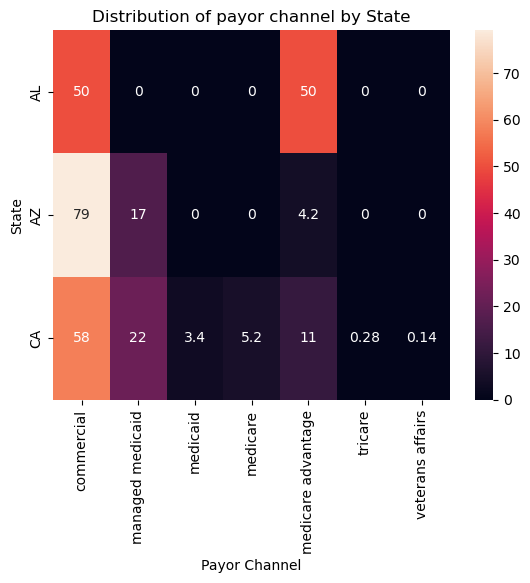

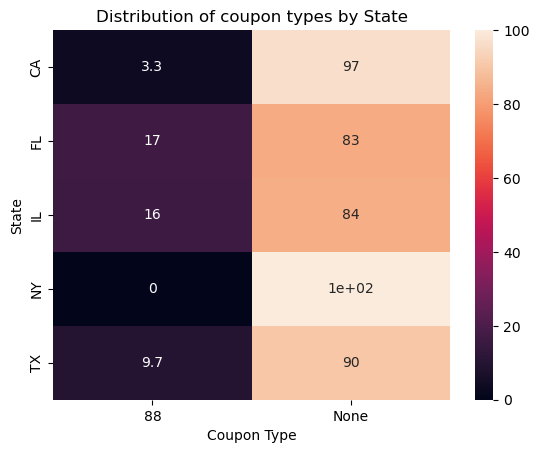

In [133]:
#Percentages of visit types across states

sns.heatmap(pd.crosstab(filtered_df1['patient_state'], filtered_df1['payor_channel'], normalize='index') * 100,
            annot=True)  
plt.title('Distribution of payor channel by State')
plt.ylabel('State')
plt.xlabel('Payor Channel')
plt.show()



sns.heatmap(pd.crosstab(filtered_df2['patient_state'], filtered_df2['coupon_type'], normalize='index') * 100,
            annot=True)  
plt.title('Distribution of coupon types by State')
plt.ylabel('State')
plt.xlabel('Coupon Type')
plt.show()

##### Intrepretation:
* For California, Arizona, payor channels which are commerical are more common for Ozempic Treatment
* Most of the payments made in California, Texas are without the usage of any coupons, these payments are amde out of pocket

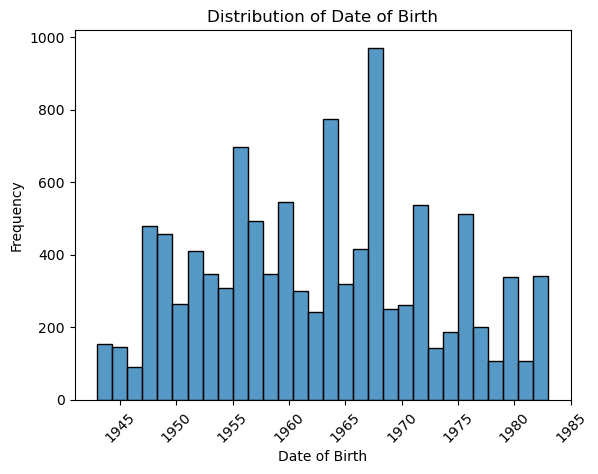

In [134]:
#DOB Based Ozempic Patients

dfplot=pd.to_datetime(filtered_df2['patient_dob']).dt.year.sort_values(ascending=False)
sns.histplot(dfplot, bins=30)
plt.title('Distribution of Date of Birth')
plt.xlabel('Date of Birth')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

##### intrepretation:
* Ozempic patients currently are aged 60-80 and were born around 1960-1980

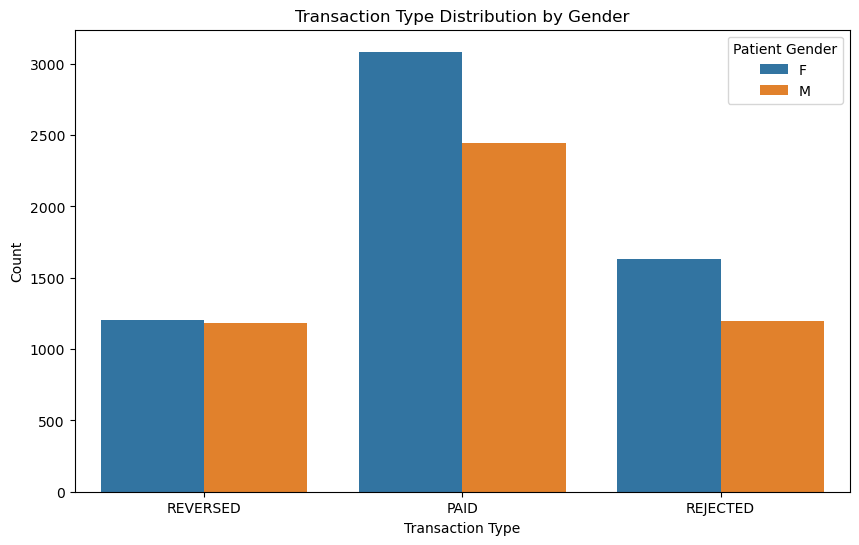

In [135]:
plt.figure(figsize=(10, 6))
sns.countplot(data=filtered_df2, x='transaction_type', hue='patient_gender')
plt.title('Transaction Type Distribution by Gender')
plt.xlabel('Transaction Type')
plt.ylabel('Count')
plt.legend(title='Patient Gender')
plt.show()

#####  Intrepretation:
* For transactions, females ozempic patients have completed their payments. Transaction reversal rates are same for males and females

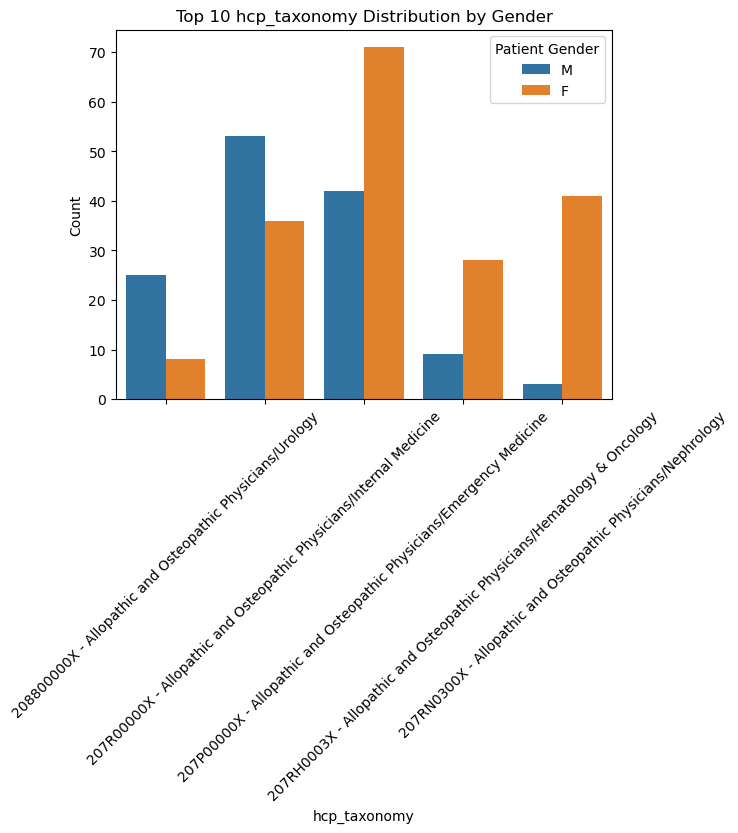

In [136]:
#5 top hcp taxonomgy based on gender
top10 = filtered_df1['hcp_taxonomy'].value_counts().head(5).index.tolist()

df_top10 = filtered_df1[filtered_df1['hcp_taxonomy'].isin(top10)]
sns.countplot(data=df_top10, x='hcp_taxonomy', hue='patient_gender')
plt.title('Top 10 hcp_taxonomy Distribution by Gender')
plt.xlabel('hcp_taxonomy')
plt.ylabel('Count')
plt.legend(title='Patient Gender')
plt.xticks(rotation=45)  
plt.show()

##### Intrepretation:
HCP or Healthcare Provider Taxonomy- refers to a code that is a inqiue 10 character code for classifying and specifiying any specialisation 
* Female ozempic patients are treated under "emergency" medicine  primarily. This could signifiy that late detection of need for Ozempic. For males, it is mostly used under "internal or physician" medicine. This trend signifies that need for Ozempic is not properly or timely expected.

In [137]:
filtered_df1.head()

,journey_id,episode_id,visit_id,encounter_id,claim_date,patient_state,patient_short_zip,patient_age,patient_gender,place_of_service,...,diag_4,diag_5,rev_center_code,rev_center_units,proc_code,proc_modifier,proc_units,line_charge,claim_charge,smart_allowed
216,000450be3d71b0ec84e8e6edf40aadfa,d6f7433d88f652d21ec4785213d9d6d6,9834663a4e711e9a3d177f920af74f88109c3d1e7ebd90...,105f4acb7474e5566edcd206e4440c66904940b0663c0a...,2022-02-22,CA,921.0,65.0,F,NaN,...,K219,J45909,636.0,1.0,J3490,NaN,2.0,7.2,7.2,343.99
1055,000f72e2fe46f4f45744f3a7f64894ce,5d98f1c8547ab6d9d011d0af82075dd1,2933e3a18ce67fcfdea4cf7325cb08a3c5b18838ff00cf...,4bc39aef0830e76dab96d91f0670cce3b6952bb656927d...,2023-06-02,CA,921.0,40.0,F,Office,...,H1033,I10,NaN,1.0,J3490,NaN,1.0,5.0,5.0,343.99
1059,000f72e2fe46f4f45744f3a7f64894ce,5d98f1c8547ab6d9d011d0af82075dd1,4edb9cf9f5b7729d5a7e92da5c5a34cd98a5a65079c210...,009e00ca9a6481a7a00528ea05d02ec36665e6c18ac677...,2023-03-31,CA,921.0,40.0,F,Office,...,F419,I10,NaN,1.0,J3490,NaN,1.0,5.0,5.0,343.99
1068,000f72e2fe46f4f45744f3a7f64894ce,5d98f1c8547ab6d9d011d0af82075dd1,49958f367eaf1cc03f642ee5bc445c6ca3dc54978cb630...,254475ba0759ea013a6a699e5d55eb7de848bbd1671c94...,2023-06-16,CA,921.0,40.0,F,Office,...,Z733,R454,NaN,1.0,J3490,NaN,1.0,30.0,30.0,343.99
1388,0012fd7f7c19414e99dd240c9b4b1952,14798cad0694a0353daef6c1184ebb21,d07de1c29e2805819a86841cf96760aaaad3aac48ea17c...,ec64f956755be1fcd4285a00cdaa62beb0fc657026bc38...,2022-11-02,CA,911.0,70.0,F,NaN,...,NaN,NaN,636.0,1.0,J3490,NaN,2.0,124.0,124.0,343.99


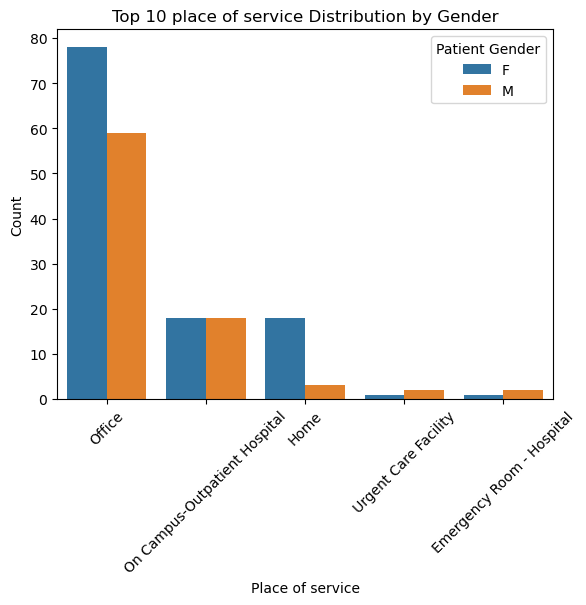

In [138]:
#5 top diagnosis_code_type based on gender
top10 = filtered_df1['place_of_service'].value_counts().head(5).index.tolist()

df_top10 = filtered_df1[filtered_df1['place_of_service'].isin(top10)]
sns.countplot(data=df_top10, x='place_of_service', hue='patient_gender')
plt.title('Top 10 place of service Distribution by Gender')
plt.xlabel('Place of service')
plt.ylabel('Count')
plt.legend(title='Patient Gender')
plt.xticks(rotation=45)  
plt.show()

##### Intrepretation:
* Ozempic doses are most commonly administered in office for both the female and male patients, followed by out-patient hospitals. The trends are the same for both men and women across different places of services.